## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [5]:
from main import *
ari = ARI()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [6]:
case1, case2 = ari.load_data()

case1_qinv = ari.quadratic_inversion(case1)
case2_qinv = ari.quadratic_inversion(case2)

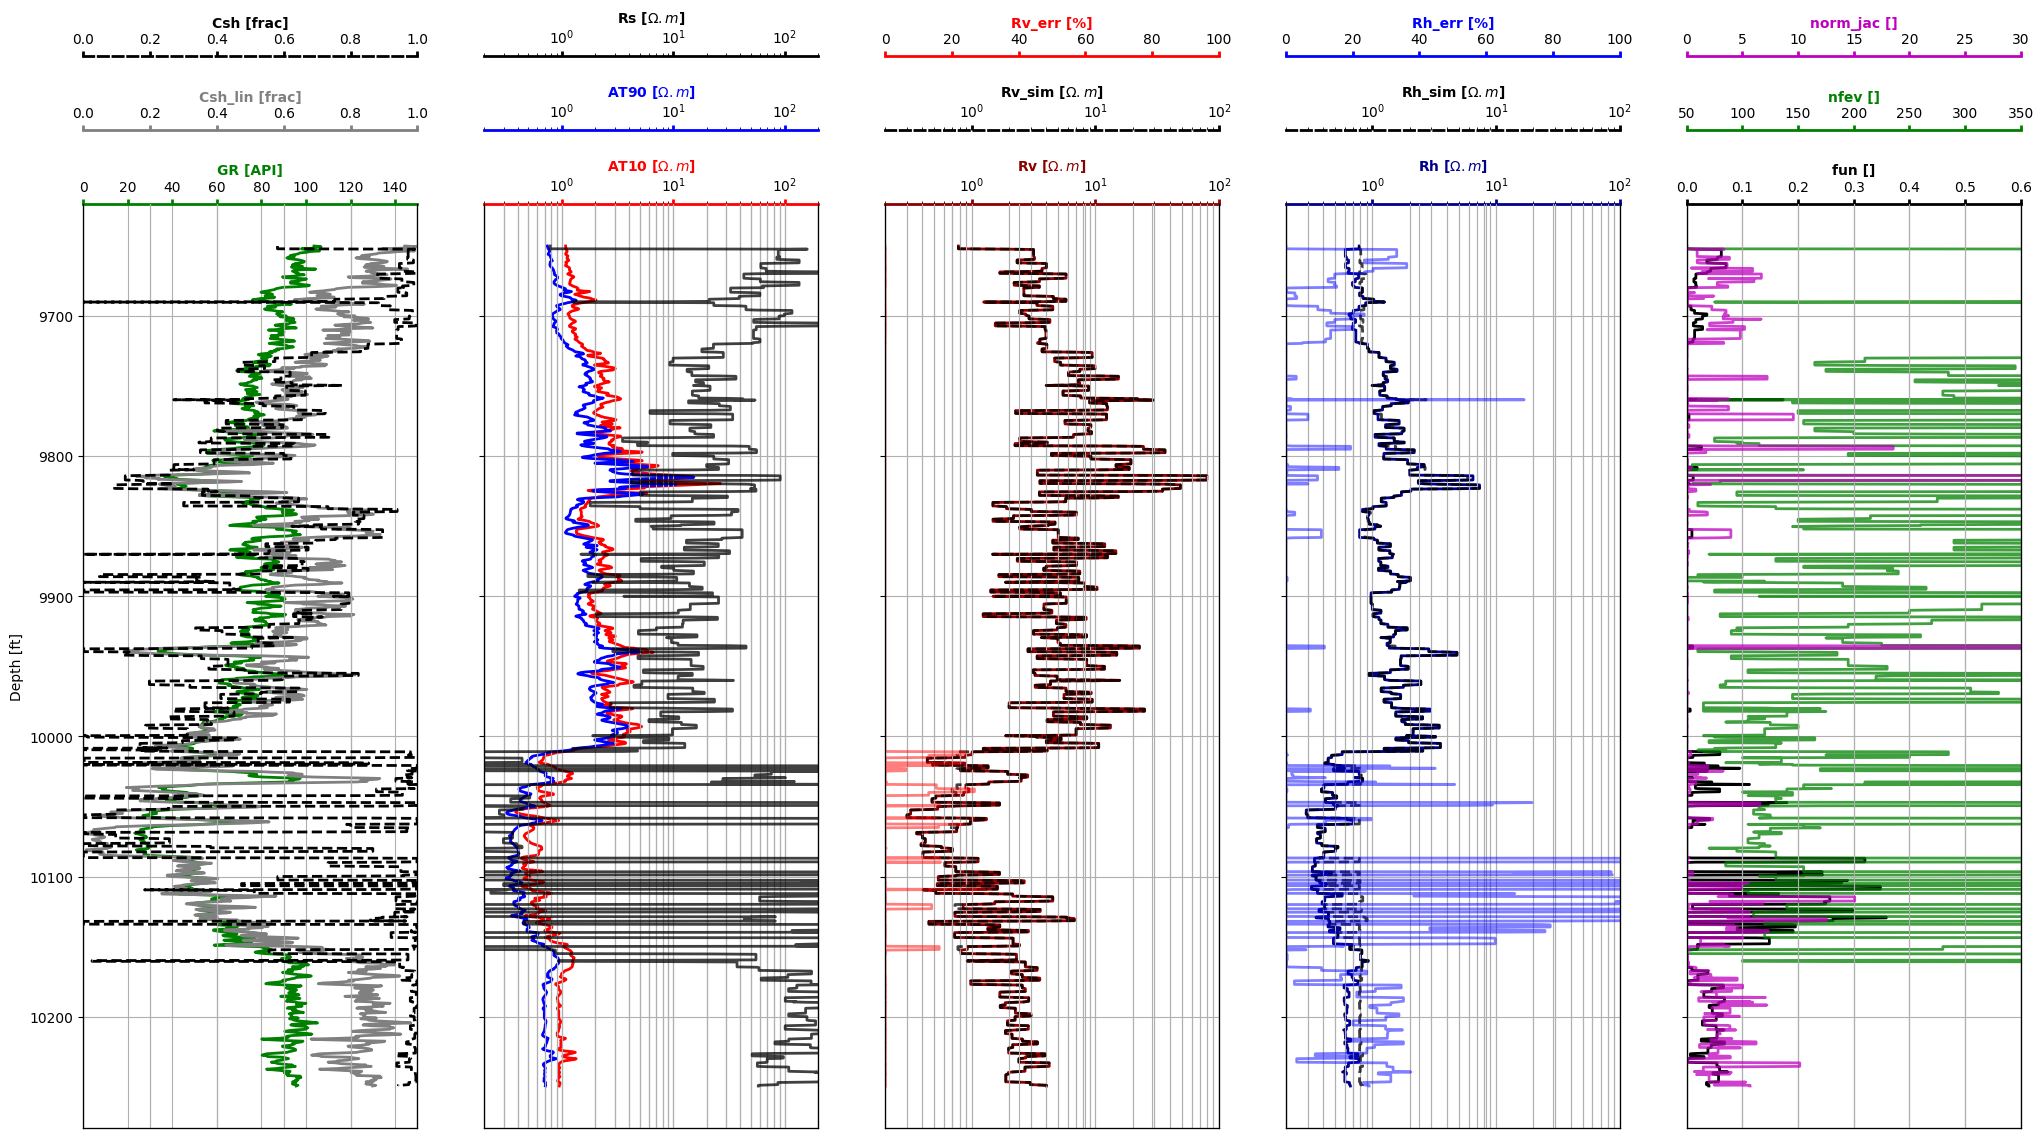

In [7]:
inv1 = ari.resistivity_inversion(case1)
ari.plot_inversion_results(inv1)

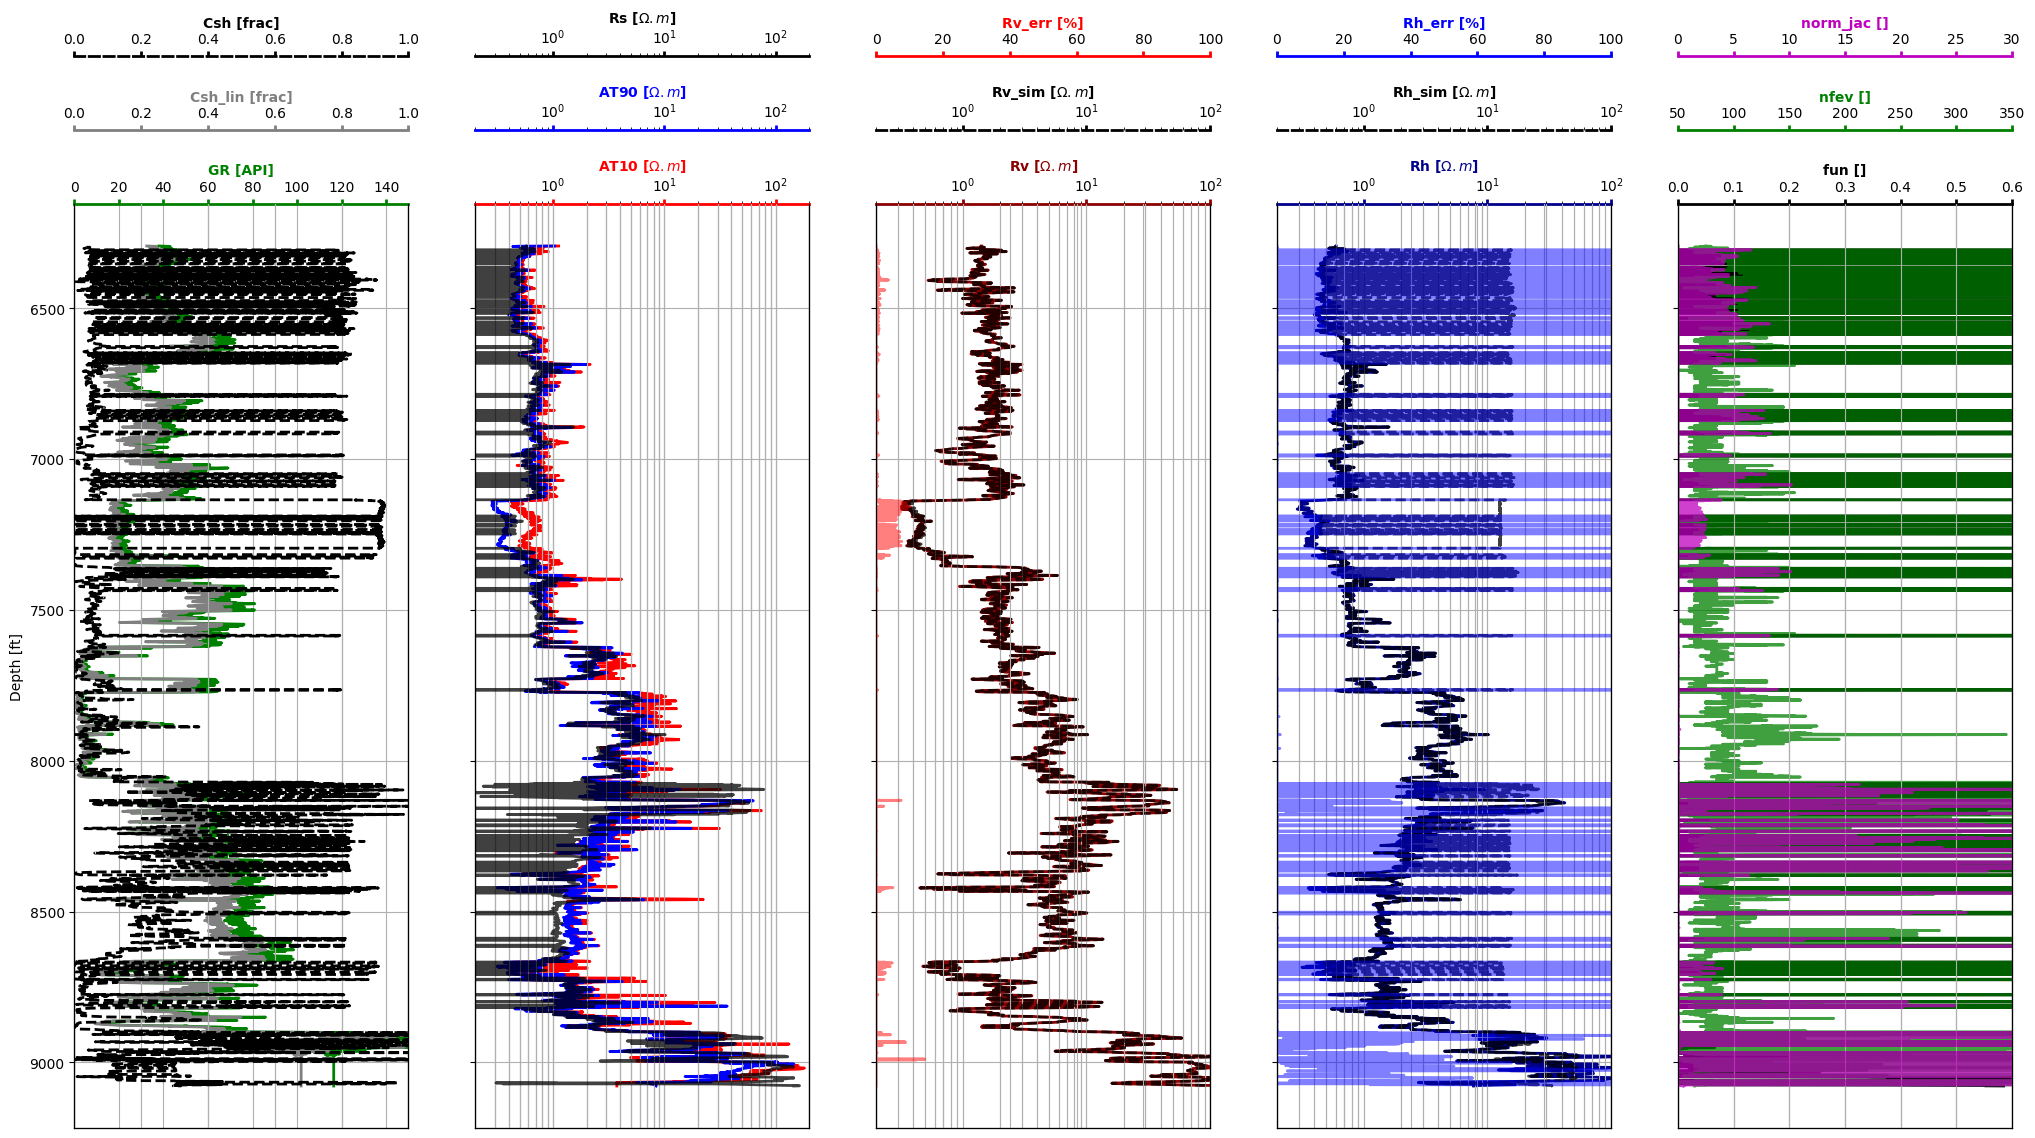

In [4]:
inv2 = ari.resistivity_inversion(case2)
ari.plot_inversion_results(inv2)

***
# END